# Simulating Microeconomic Models

In the [Gentle Introduction to HARK](./Gentle-Intro-To-HARK.ipynb), we showed the basics of using HARK to make instances of `AgentType` subclasses, specify their parameters, solve their dynamic model, and examine the solution. In this notebook, we continue the introduction by demonstrating how to generate simulated model data with HARK.

## Example model: Consumption-saving with income risk

Because it's our fundamental workhorse consumption-saving model, we'll use the `IndShockConsumerType` as our example throughout this notebook. This `AgentType` subclass represents consumers with CRRA preferences over consumption who discount future utility flows geometrically; they face both fully permanent and fully transitory shocks to their labor income, and can save in a risk free asset.

To refresh your memory, the agent's model can be written in Bellman form as: $\newcommand{\LivPrb}{\mathsf{S}}$

\begin{align*}
v_t(m_t) &= \max_{c_t} u(c_t) + \LivPrb_t \beta \mathbb{E} [(\Gamma_{t+1}\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ] ~~ \text{s.t.} \\
a_t &= m_t - c_t, \\
a_t &\geq \underline{a}, \\
k_{t+1} &= a_t, \\
b_{t+1} &= R_{t+1}/(\Gamma_{t+1} \psi_{t+1}) k_{t+1}, \\
m_{t+1} &= b_{t+1} + \theta_{t+1},\\
(\psi_{t+1},\theta_{t+1}) &\sim F_{t+1}, \\
\mathbb{E}[\psi_t]&=\mathbb{E}[\theta_t] = 1, \\
u(c) &= \frac{c^{1-\rho}}{1-\rho}.
\end{align*}

The model's parameters are summarized below.

| Param | Description | Code | Value |
| :---: | ---  | :---: | :---: |
| $\rho$ | Relative risk aversion | `CRRA` | 2.0 |
| $\beta$ | Discount factor | `DiscFac` | 0.96 |
| $R$ | Risk free interest factor | `Rfree` | 1.03 |
| $\LivPrb$ | Survival probability | `LivPrb` | 0.98 |
| $\Gamma$ | Income growth factor | `PermGroFac` | 1.01 |
| $\underline{a}$ | Artificial borrowing constraint | `BoroCnstArt` | 0.0 |
| $F$ | Distribution of income shocks | `IncShkDstn` | * |

The agent's **normalized market resources** $m_t$ are a sufficient statistic to make their choice of **normalized consumption** $c_t$ because the model is homothetic with respect to permanent income. At the beginning of period $t$, the agent's permanent income grows by factor $\Gamma_t$ in expectation, subject to **permanent income shock** $\psi_t$. Their non-capital income is also subject to a **transitory income shock** $\theta_t$. For the purposes of this notebook, we won't go into the details of the income shock distribution $F_t$.

First, let's import our `AgentType` subclass and some basic tools, and make an instance of the class using the default parameters. 

In [1]:
# Import basic tools into our workspace
import numpy as np
import matplotlib.pyplot as plt
from time import time
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

# Make and solve an instance of IndShockConsumerType with default parameters
MyType = IndShockConsumerType(cycles=0)
MyType.solve()

Note that `MyType` was specified as an infinite horizon type with `cycles=0`.

## How to make simulated data: Legacy method

Suppose we want to see what would happen if many agents live out this model over time, generating a **simulated population history**. In the "legacy" simulation system that HARK has used since its inception, the `AgentType.simulate()` method makes such a history by **Monte Carlo** simulation with a fixed population size. Whenever an agent in the population dies, they are replaced with a "newborn" at the start of the next period.

To begin, we need to specify two extra parameters, which are universal across HARK models. HARK needs to know **how many** agents to simulate, and **for how many periods** the model should be run.

| Param | Description | Code | Value |
| :---: | ---  | :---: | :---: |
| $N$ | Number of agents of this type in simulation | `AgentCount` | 10000 |
| $T_{sim}$ | Maximum number of periods we want to simulate | `T\_sim` | 100 |

In [2]:
# Tell our AgentType instance to simulate 10000 consumers for 100 periods.
MyType.AgentCount = 10000
MyType.T_sim = 100

Moreover, we need to tell HARK which model variables we're interested in: what information to actually **track** when simulating the model. This is done by setting the `track_vars` attribute as a list of strings that name the variables you want. For now, let's track normalized consumption $c_t$ and end-of-period normalized assets $a_t$, which are called `cNrm` and `aNrm` in HARK.

In [3]:
# Indicate that we want to track consumption, assets, and permanent income
MyType.track_vars = ["cNrm", "aNrm", "pLvl"]

To simulate the model, we first need to **initialize** the simulation, resetting it back to a starting state, then simply call the `simulate` method on our `AgentType` instance. For a simple model like this, simulation doesn't take long at all.

An `AgentType` is initialized for simulation with the `initialize_sim()` method, and actually simulated with the `simulate()` method.

In [4]:
# Simulate the model and report the time it took
t0 = time()
MyType.initialize_sim()
MyType.simulate()
t1 = time()
print(
    "Simulating the infinite horizon consumption-saving model took {:.3f}".format(
        t1 - t0
    )
    + " seconds."
)

Simulating the infinite horizon consumption-saving model took 0.455 seconds.


## Visualizing simulated data

The **history** of simulated model outcomes is stored in the attribute `history`, a dictionary of arrays. The keys for the dictionary are the variables named in `track_vars`, and the entries are arrays of shape $(T_{sim},N)$. For example, we can plot average (normalized) consumption and wealth by period.

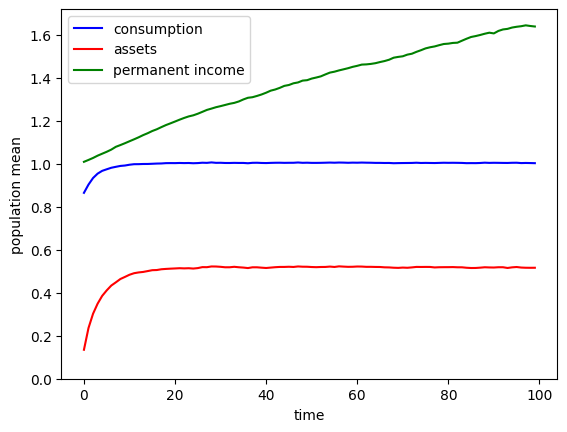

In [5]:
# Plot population averages for the simulated period
A = np.mean(MyType.history["aNrm"], axis=1)
C = np.mean(MyType.history["cNrm"], axis=1)
P = np.mean(MyType.history["pLvl"], axis=1)
plt.plot(C, "-b", label="consumption")
plt.plot(A, "-r", label="assets")
plt.plot(P, "-g", label="permanent income")
plt.xlabel("time")
plt.ylabel("population mean")
plt.ylim(0.0, None)
plt.legend()
plt.show()

Notice that the population averages of *normalized* variables reach their long run steady state rather quickly, but permanent income *level* keeps rising. This is because of the permanent income growth factor of $\Gamma = 1.01$, so that **survivors** have their permanent income grow steadily each period. If we simulated the model for a lot longer, the green plot would also level off.

We could also plot the time series of assets for one particular consumer, like so.

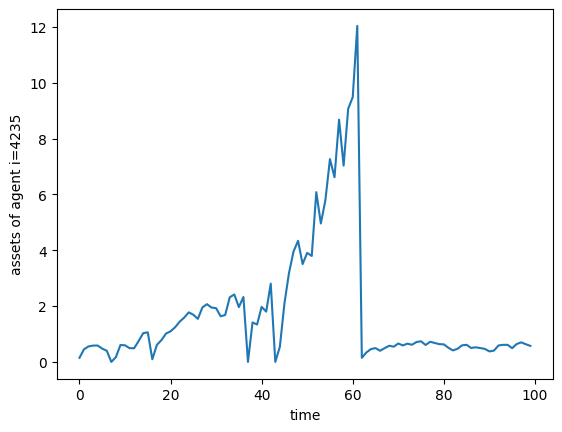

In [6]:
# Extract asset time series for one agent and plot it
i = 4235  # choose an agent index
a_i = MyType.history["aNrm"][:, i]
p_i = MyType.history["pLvl"][:, i]
plt.plot(a_i * p_i)  # plot assets in level
plt.xlabel("time")
plt.ylabel("assets of agent i=" + str(i))
plt.show()

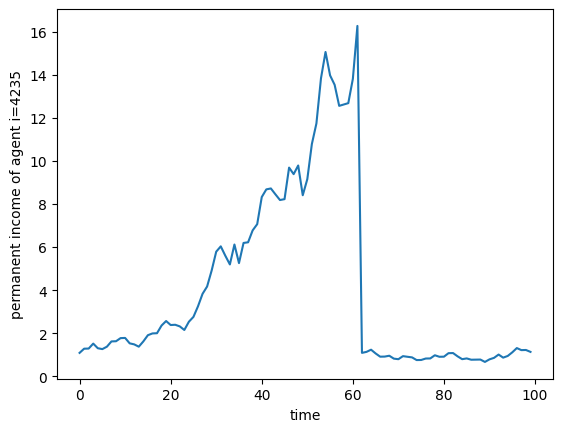

In [7]:
# Plot permanent income for one agent
plt.plot(p_i)
plt.xlabel("time")
plt.ylabel("permanent income of agent i=" + str(i))
plt.show()

Whoa, what happened to Mr. 4235 around $t=62$? He had very high income, and then suddenly crashed back down! Dear reader, I regret to inform you that our dearly beloved original Mr. 4235 **died** and was replaced with a new Mr. 4235 at $t=62$. We show these plots to emphasize the death-and-replacement style of simulation in HARK.

In this case, the time series plot is dramatic, but that's not always so. How can a user tell when a simulated agent has died and been replaced? The `t_age` variable represents **the number of periods an agent has lived** at the end of the period; it is thus always at least 1.

To see this, we can reset the simulation, add `"t_age"` to `track_vars`, and simulate the model again. Mr. 4235's time series of age will then be two increasing lines with a drop at $t=62$.

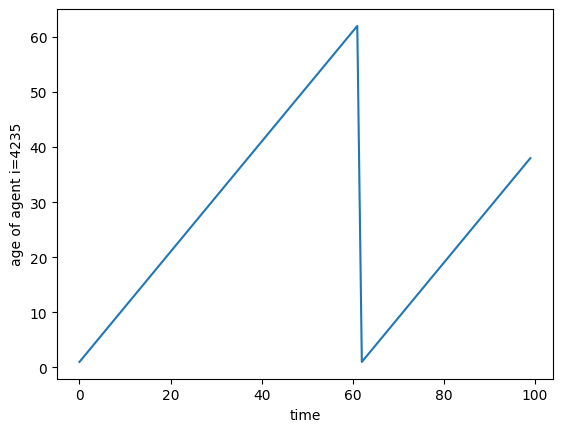

In [8]:
# Re-simulate the model
MyType.track_vars.append("t_age")
MyType.initialize_sim()
MyType.simulate()

# Plot one agent's time series of periods lived
t_i = MyType.history["t_age"][:, i]
plt.plot(t_i)  # plot assets in level
plt.xlabel("time")
plt.ylabel("age of agent i=" + str(i))
plt.show()

## Initializing agents: model "birth"

A "birth" event happens for *all* agents when `initialize_sim()` is called, and automatically over the course of the simulation when agents die and are replaced.

When model agents are "born", their initial state is drawn from some distribution using the `sim_birth()` method (internally by HARK). Most of HARK's `AgentType` subclasses share the same `sim_birth()` method, with some small variations: initial (normalized) capital holdings $k_t$ are drawn from the distribution `kNrmInitDstn` and initial permanent income level $p_t$ is drawn from `pLvlInitDstn`. Both of those distributions are specified as lognormal by default, but this distributional assumption can be changed.

The parameters of these default distributions (and their values) are as follows:

| Description | Code | Value |
| ---  | :---: | :---: |
| Mean of initial log normalized capital | `kLogInitMean` | -12. |
| Stdev of initial log normalized capital  | `kLogInitStd` | 0.0 |
| Number of nodes in initial capital dstn  | `kLogInitCount` | 15 |
| Mean of initial log permanent income | `pLogInitMean` | 0.0 |
| Stdev of initial log permanent income  | `pLogInitStd` | 0.0 |
| Number of nodes in initial perm inc dstn  | `pLogInitCount` | 15 |

Note that the distributional parameters are given in *logs*, so the default setting is for newborn `IndShockConsumerType` agents to have (nearly) zero capital and permanent income of 1, with no variation. When the standard deviations are set to positive values, the initial distributions will be approximated with equiprobable discretizations with 15 nodes each.

## Manually altering simulation outcomes

*Most* of the time, you want to just simulate all of the periods of your model, but *sometimes* you want to do something more unusual. Suppose that you were interested in seeing what happens if you give all agents additional wealth equal to 10\% of their permanent income. How could this be done?

As an **optional argument**, you can call the `simulate` method with an integer value to simulate *only* that number of periods, and then stop. The `history` arrays will have empty values in periods that have not yet been simulated. The **current state** of the simulation is stored as a dictionary in the `state_now` attribute, where each entry is a vector of size `AgentCount` idiosyncratic values. The values in this array can be manipulated in the middle of the simulation to handle such unusual events. 

In [9]:
# Reset the simulation and have it run for a longer time
MyType.T_sim = 200
MyType.initialize_sim()

# Simulate the model for 100 periods
MyType.simulate(100)

# Give everyone an extra 10% of their permanent income
MyType.state_now["aNrm"] += 0.1

# Simulate the remaining 100 periods
MyType.simulate(100)

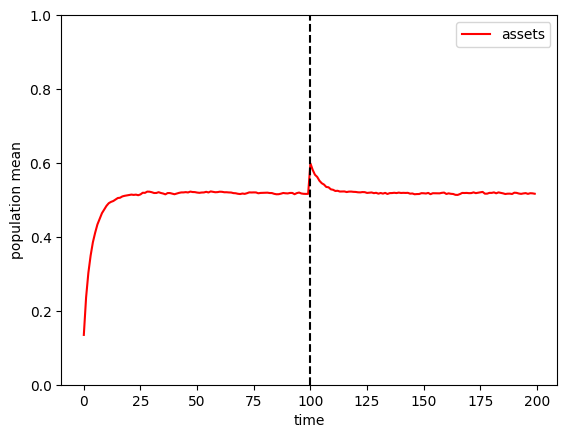

In [10]:
# Plot the aggregate time series of normalized wealth
A = np.mean(MyType.history["aNrm"], axis=1)
plt.plot(A, "-r", label="assets")
plt.plot([100, 100], [0.0, 20], "--k")
plt.xlabel("time")
plt.ylabel("population mean")
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()

This simple example lets us see how the population spends down an unexpected windfall, returning to the steady state fairly quickly.

## Pre-drawing and manipulating shocks

In some cases, the variable that you want to manipulate is a **shock** that happens during the period, not simply adjusting states "between" periods. To accomplish this, you can pre-specify the shocks that will occur over the course of the simulation.

If the attribute `read_shocks` is set to `True` (it is `False` by default), then rather than draw shock variables like $\psi_t$ and $\theta_t$ on the fly each period, the simulator will instead read them from the dictionary attribute `shock_history`. You can manually create the history arrays for `shock_history`, or they can be automatically generated by running the `make_shock_history()` method (which also sets `read_shocks` to `True`).

**NB:** You have to run `initialize_sim` after running `make_shock_history()`, but this does not destroy `shock_history`.

As an example of this, let's pre-draw the shock variable history, then have everyone get a transitory shock of $\theta_t=0$ at $t=70$.

In [11]:
# Reset the simulation once again, and pre-draw the shock history
MyType.initialize_sim()
MyType.make_shock_history()

# Have everyone get a transitory shock of zero at t=70
MyType.shock_history["TranShk"][70, :] = 0.0

# Re-initialize and simulate all 200 periods
MyType.initialize_sim()
MyType.simulate()

/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/HARK/core.py:1415: UserWarning: The option for reading shocks was activated but the model requires state PlvlAgg, not contained in newborn_init_history.
  warn(
/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/HARK/core.py:1783: UserWarning: The option for reading shocks was activated but the model requires state PlvlAgg, not contained in newborn_init_history.
  warn(


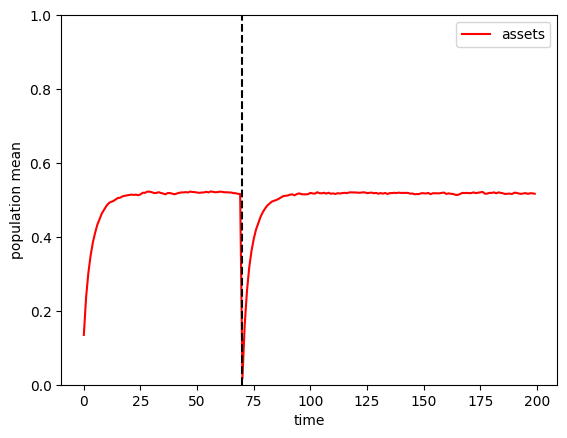

In [12]:
# Plot the aggregate time series of normalized wealth
A = np.mean(MyType.history["aNrm"], axis=1)
plt.plot(A, "-r", label="assets")
plt.plot([70, 70], [0.0, 20], "--k")
plt.xlabel("time")
plt.ylabel("population mean")
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()

In this case, our agents are all sufficiently impatient that getting no income for one period meant that *almost* all of them ended up on the liquidity constrained portion of their consumption function at $t=70$ and thus end the period with zero assets. The only exceptions are those who happened to have a lot of cash on hand (relative to their permanent income) at the end of $t=69$, perhaps because they had recently experienced a large negative permanent income shock.

## Lifecycle simulation

The examples above all used a basic infinite horizon model, but HARK is also meant for lifecycle problems. The legacy simulator handles these models just fine, but they can be somewhat slower to execute.

HARK has some tools for importing calibrations of lifecycle processes, including mortality and income profiles. First, let's bring those into our environment, then make a lifecycle version of an `IndShockConsumerType`. Below, we make a lifecycle dictionary that draws on income growth profiles from Cocco, Gomes, and Mahout; income risk profiles from Sabelhous and Song; and mortality profiles from the Social Security Administration.

In [13]:
# Import some stuff from the Calibration submodule
from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.Calibration.life_tables.us_ssa.SSATools import parse_ssa_life_table

In [14]:
# Specify some choices
birth_age = 25
death_age = 110
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

LivPrb = parse_ssa_life_table(
    female=True,
    cross_sec=True,
    year=2004,
    age_min=birth_age,
    age_max=death_age,
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Make a dictionary for our lifecycle agent
lifecycle_dict = {}
lifecycle_dict.update(income_params)
lifecycle_dict["LivPrb"] = LivPrb
lifecycle_dict.update(time_params)
lifecycle_dict["Rfree"] = lifecycle_dict["T_cycle"] * [1.02]

In [15]:
# Make and solve a lifecycle agent type
LCtype = IndShockConsumerType(**lifecycle_dict)
LCtype.solve()

We can initialize and simulate this `AgentType` instance the same as before, but notice that it will take somewhat longer to run.

In [16]:
# Set up the simulation
LCtype.AgentCount = 10000
LCtype.T_sim = 100
LCtype.track_vars = ["aNrm", "cNrm", "pLvl", "t_age"]

# Run the simulation
t0 = time()
LCtype.initialize_sim()
LCtype.simulate()
t1 = time()
print("Simulating the lifecycle model took {:.3f}".format(t1 - t0) + " seconds.")

Simulating the lifecycle model took 2.200 seconds.


It took about 4-5x longer to simulate the same number of agents for the same number of periods as the infinite horizon model-- why? In the infinite horizon model, all of the agents shared the same consumption function and other parameters each period, and the simulation math could be done for all agents at once with fully vectorized operations. In the lifecycle model, on the other hand, agents *don't* necessarily all share model information, because they might be in different model ages within the same period. Thus the simulator needs to check *who is what age* in each period and apply the correct information to each group.

Just as before, we can make plots of simulation outcomes.

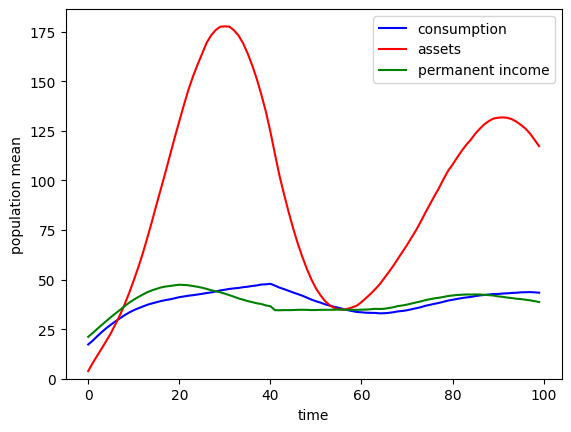

In [17]:
# Plot population averages for the simulated period
A = np.mean(LCtype.history["aNrm"] * LCtype.history["pLvl"], axis=1)
C = np.mean(LCtype.history["cNrm"] * LCtype.history["pLvl"], axis=1)
P = np.mean(LCtype.history["pLvl"], axis=1)
plt.plot(C, "-b", label="consumption")
plt.plot(A, "-r", label="assets")
plt.plot(P, "-g", label="permanent income")
plt.xlabel("time")
plt.ylabel("population mean")
plt.ylim(0.0, None)
plt.legend()
plt.show()

Hey, what's going on here? Why is the profile of normalized assets so *wavy*? It's because the simulation we ran began with *everyone* at model age 0 (representing age 25), but people died and were replaced at different ages along the way. In the first few years, almost everyone is part of the original cohort, but by around $t=60$, about half of the population has already died at least once and is much younger than 85 years old. The distribution of age in the population is *far* from its long run ergodic shape, and those waves will continue for quite a while.

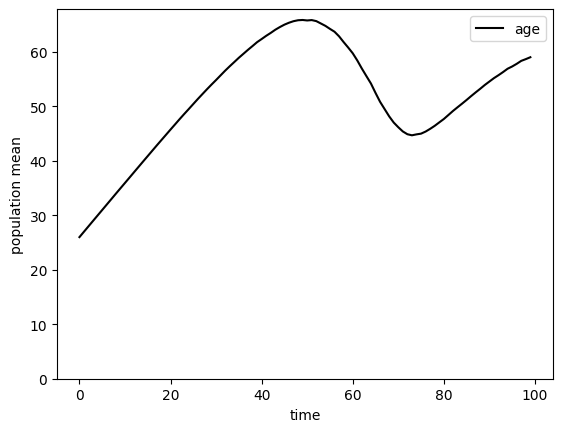

In [18]:
# Plot population average age
T = np.mean(LCtype.history["t_age"], axis=1)
plt.plot(T + birth_age, "-k", label="age")
plt.xlabel("time")
plt.ylabel("population mean")
plt.ylim(0.0, None)
plt.legend()
plt.show()

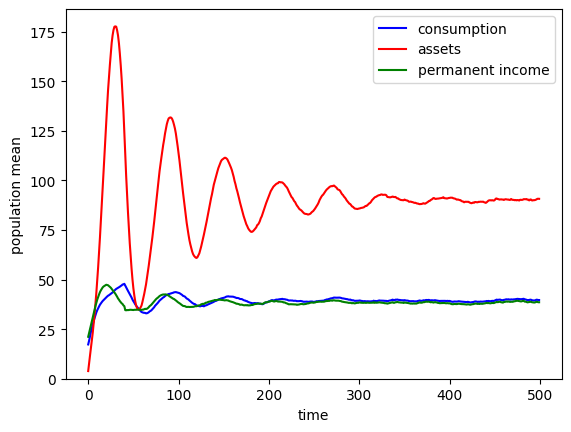

In [19]:
# Repeat the same exercise, but with a much longer time horizon
LCtype.T_sim = 500
LCtype.initialize_sim()
LCtype.simulate()

# Plot population averages simulated period
A = np.mean(LCtype.history["aNrm"] * LCtype.history["pLvl"], axis=1)
C = np.mean(LCtype.history["cNrm"] * LCtype.history["pLvl"], axis=1)
P = np.mean(LCtype.history["pLvl"], axis=1)
plt.plot(C, "-b", label="consumption")
plt.plot(A, "-r", label="assets")
plt.plot(P, "-g", label="permanent income")
plt.xlabel("time")
plt.ylabel("population mean")
plt.ylim(0.0, None)
plt.legend()
plt.show()

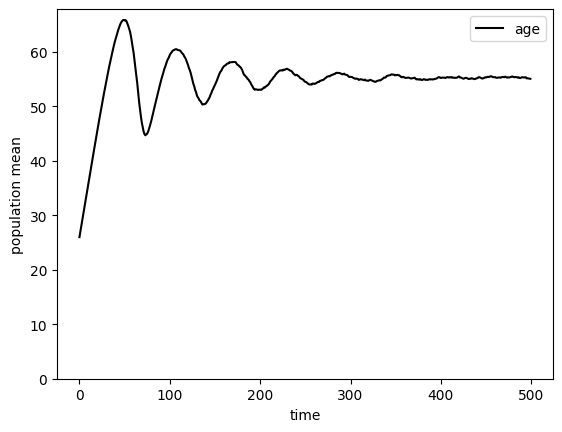

In [20]:
# Plot population average age
T = np.mean(LCtype.history["t_age"], axis=1)
plt.plot(T + birth_age, "-k", label="age")
plt.xlabel("time")
plt.ylabel("population mean")
plt.ylim(0.0, None)
plt.legend()
plt.show()

After about **500 years**, the mean of model age has just about settled down. Recall that `t_age` holds model age for each simulated agent. We can make a plot of the (approximate) steady stage age distribution.

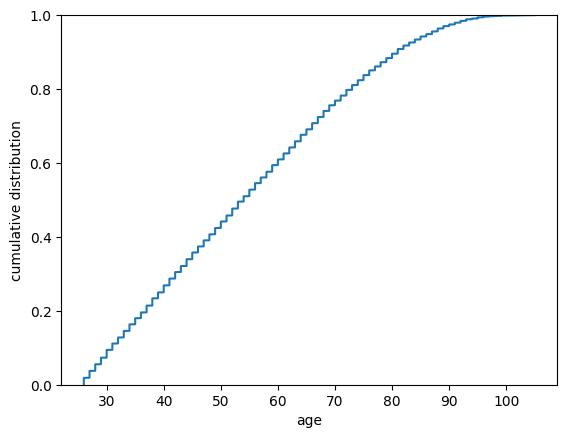

In [21]:
# Plot the distribution of age after 500 simulated years
age_all = np.sort(LCtype.t_age + birth_age)
CDF = np.linspace(0.0, 1.0, age_all.size)
plt.plot(age_all, CDF)
plt.xlabel("age")
plt.ylabel("cumulative distribution")
plt.ylim(0.0, 1.0)
plt.show()

We can compare this to the *exact* ergodic age distribution by doing a little math. Let's use the cumulative survival probabilities by age to find the exact distribution, then compare it to the approximate empirical one.

In [22]:
# Find the long run age distribution
CumLivPrb = np.cumprod(np.concatenate(([1.0], LivPrb)))
AgeDstn = CumLivPrb / np.sum(CumLivPrb)
CDFtrue = [0.0]
AgeTrue = [birth_age]
for t in range(LCtype.T_cycle + 1):
    j = t + birth_age
    AgeTrue.append(j + 1)  # recorded age is at *end* of period
    AgeTrue.append(j + 1)
    CDFtrue.append(CDFtrue[-1])
    CDFtrue.append(CDFtrue[-1] + AgeDstn[t])

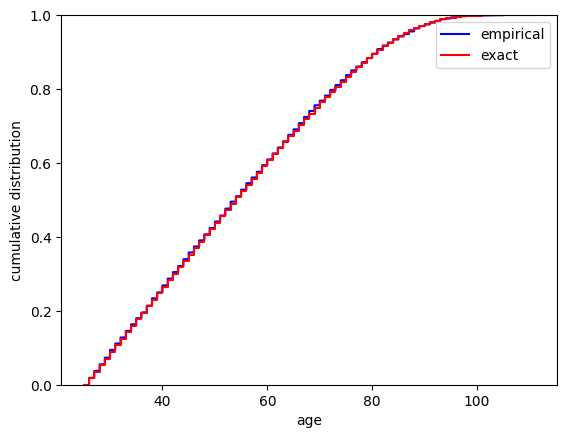

In [23]:
# Make a comparison plot of empirical vs exact age distribution
plt.plot(age_all, CDF, "-b", label="empirical")
plt.plot(AgeTrue, CDFtrue, "-r", label="exact")
plt.xlabel("age")
plt.ylabel("cumulative distribution")
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()

## New way? What's this about a new way?

Earlier, we referred to `simulate()` as the "legacy" simulation method. HARK also has a new, developmental simulation structure that is meant to eventually replace the legacy version. For now, it sits alongside it as a redundant system, and is used to construct sequence space Jacobians. 

The syntax to use the new-style simulator is nearly identical to the legacy one, but with the `i` in `sim` swapped for a `y` in method names. Analogously, the results of the simulation are written to the `hystory` attribute rather than `history`. Otherwise, the basic usage is identical.

**NB:** The new simulation structure has some features that the old one does not, but it currently lacks some features that the old method has. E.g. there is currently no nice "interface" to manipulate simulated outcomes after running some (but not all) periods; we are adding this soon.

In [24]:
# Make and solve a default infinite horizon consumer
TestType = IndShockConsumerType(cycles=0)
TestType.solve()

# Set some simulation parameters
TestType.T_sim = 100
TestType.AgentCount = 10000
TestType.track_vars = ["cNrm", "aNrm", "pLvl"]

In [25]:
# Simulate the model using the old method
t0 = time()
TestType.initialize_sim()
TestType.simulate()
t1 = time()
print("The old simulation method took {:.3f}".format(t1 - t0) + " seconds.")

# Simulate the model using the new method
t0 = time()
TestType.initialize_sym()
TestType.symulate()
t1 = time()
print("The new simulation method took {:.3f}".format(t1 - t0) + " seconds.")

The old simulation method took 0.440 seconds.


The new simulation method took 0.393 seconds.


The new simulation method *usually* runs a little faster than the old one, but not always. The results can be plotted against each other to confirm that both versions produce identical results, up to random draws.

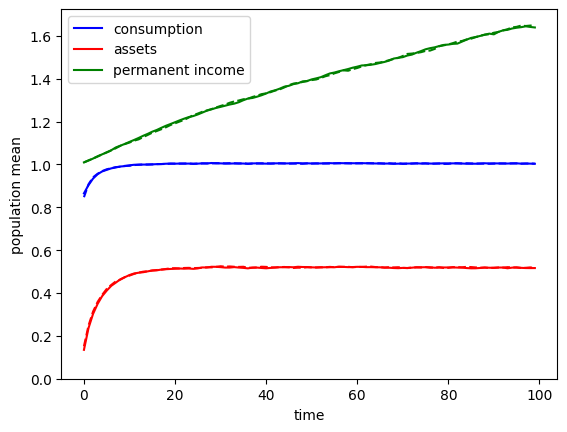

In [26]:
# Compare population averages for the simulated period
A0 = np.mean(TestType.history["aNrm"], axis=1)
C0 = np.mean(TestType.history["cNrm"], axis=1)
P0 = np.mean(TestType.history["pLvl"], axis=1)
A1 = np.mean(TestType.hystory["aNrm"], axis=1)
C1 = np.mean(TestType.hystory["cNrm"], axis=1)
P1 = np.mean(TestType.hystory["pLvl"], axis=1)
plt.plot(C0, "-b", label="consumption")
plt.plot(A0, "-r", label="assets")
plt.plot(P0, "-g", label="permanent income")
plt.plot(C1, "--b")
plt.plot(A1, "--r")
plt.plot(P1, "--g")
plt.xlabel("time")
plt.ylabel("population mean")
plt.ylim(0.0, None)
plt.legend()
plt.show()

In the figure above, the solid lines are the means produced by the old simulation system, and the dashed lines are produced by the new system.

More complete information about the new simulation system can be found elsewhere, but the most important thing to know is that the model for the `AgentType` subclass can be printed to screen using the `describe_model()` method. This is the easiest way within HARK to learn the names of the model variables, functions, and distributions; these names are the same for both the old and new systems.

In [27]:
TestType.describe_model()

ConsIndShock: Consumption-saving model with permanent and transitory income shocks and a risk-free asset.

----------------------------------
%%%%%%%%%%%%% SYMBOLS %%%%%%%%%%%%
----------------------------------
kNrm (float)        : beginning of period capital, normalized by p_{t-1}
pLvlPrev (float)    : inbound permanent income level, before growth
yNrm (float)        : normalized labor income
pLvl (float)        : permanent income level
bNrm (float)        : normalized bank balances
mNrm (float)        : normalized market resources
cNrm (float)        : normalized consumption
aNrm (float)        : normalized end-of-period assets
live (bool)         : whether the agent survives
Rfree (param)       : risk free return factor on assets
PermGroFac (param)  : expected permanent income growth factor
LivPrb (param)      : survival probability at end of period
cFunc (func)        : consumption function over market resources
IncShkDstn (dstn)   : joint distribution of permanent and transitory